In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path = '/content/drive/MyDrive/עבודה בינה מלאכותית/data_base'

directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

print(directories)

['nonpd', 'pd', 'Prodromal', 'תמונות תסמינים שלא השתמשנו בהם לפיתוח מודל בגלל עודף']


In [ ]:
import os
import pandas as pd
import random

# נתיב לתקיות החולים והלא חולים

path = r'/content/drive/MyDrive/עבודה בינה מלאכותית/data_base'
patients_dir = path + r'/pd'
healthy_dir = path + r'/nonpd'



healthy_df =  pd.read_csv(path + r'/Healthy_list_for_model_1,2.csv')

# יצירת רשימות של התמונות והלייבלים
images = []
labels = []

# הוספת תמונות חולים
for filename in os.listdir(patients_dir):
    images.append(os.path.join(patients_dir, filename))
    labels.append('PD')

random.seed(25)
random.shuffle(images)

images = images[:healthy_df.shape[0]]
labels = labels[:len(images)]


# הוספת תמונות לא חולים
for _, row in healthy_df.iterrows():
    filename = str(row['File Name'])
    images.append(os.path.join(healthy_dir, filename))
    labels.append('NONPD')

# צעד 3: יצירת דאטה פריים
df = pd.DataFrame({
    'Image': images,
    'Label': labels
})



print(f'pd - nonpd ratio -> {df[df["Label"] == "PD"].shape[0]//df[df["Label"] == "NONPD"].shape[0] }:1')


# הצגת הדאטה פריים
df.head()

pd - nonpd ratio -> 1:1


,Image,Label
0,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,PD
1,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,PD
2,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,PD
3,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,PD
4,/content/drive/MyDrive/עבודה בינה מלאכותית/dat...,PD


In [ ]:
def img_to_array(iterable):
    arr = np.asarray(iterable, dtype=np.float32) / 255.0
    return arr

In [ ]:

import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical


def load_images_from_df(df):
    images = []
    labels = []

    for index, row in df.iterrows():
        image = cv2.imread(row['Image'])
        if (index + 1) % 100 == 0:
            print(f"----- {index + 1} -----")
        image = cv2.resize(image, (224, 224))
        images.append(image)
        labels.append(row['Label'])

    labels = [1 if label == 'PD' else 0 for label in labels]
    labels = to_categorical(labels)
    return images, labels


images = []
labels = []

images, labels = load_images_from_df(df)


----- 100 -----
----- 200 -----
----- 300 -----
----- 400 -----
----- 500 -----
----- 600 -----
----- 700 -----
----- 800 -----


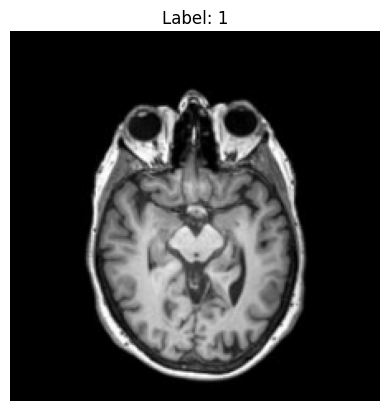

In [ ]:
# מומלץ להריץ
import matplotlib.pyplot as plt
# דוגמה להצגת מטופל לאחר חפרדת הנתונים לחולה ובריא
index = 435  # אינדקס רצוי

# בדיקה שהתמונה קיימת
if index < len(images):
    plt.imshow(img_to_array(images)[index])  # מציג את התמונה
    plt.title(f"Label: {np.argmax(labels[index])}")  # מציג את הליבל של התמונה הספציפית
    plt.axis('off')  # מסרת צירים
    plt.show()
else:
    print(f"The index {index} is out of range. Please choose a valid index.")

In [ ]:
# אסור להריץ ואסור לשנות פרמטרים זה קובע את יציבות הניסוי בחזרה עליו
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


print("Training set size:", len(X_train), f" - {round(100 * len(X_train) / df.shape[0], 2)}%")
print("Validation set size:", len(X_val), f" - {round(100 * len(X_val) / df.shape[0], 2)}%")
print("Test set size:", len(X_test), f" - {round(100 * len(X_test) / df.shape[0], 2)}%")
print(f"Total images: {df.shape[0]}")

Training set size: 561  - 63.9%
Validation set size: 141  - 16.06%
Test set size: 176  - 20.05%
Total images: 878


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

data_augmentation = Sequential([
    layers.RandomRotation(0.005),       # Apply a small random rotation (0.5%)
    layers.RandomZoom(0.1),             # Apply a small random zoom
    layers.RandomContrast(0.05),        # Apply a slight random contrast adjustment
], name="augmentation_layer")  # Name the layer for easier identification

X_train = data_augmentation(X_train)
X_train = img_to_array(X_train)
X_val = img_to_array(X_val)
X_test = img_to_array(X_test)


In [ ]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # Convert both y_true and y_pred to float32 to prevent data type issues
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    tp = K.sum(K.round(y_true * y_pred))  # Calculate true positives
    predicted_positives = K.sum(K.round(y_pred))  # Calculate predicted positives
    possible_positives  = K.sum(K.round(y_true))  # Calculate possible positives

    precision = tp / (predicted_positives + K.epsilon())  # Calculate precision
    recall    = tp / (possible_positives + K.epsilon())   # Calculate recall

    # Return the F1 score: harmonic mean of precision and recall
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# מבנה הרשת
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # שכבת קונבולוציה ראשונה
    MaxPooling2D(2, 2),  # שכבת מקסימום פולינג
    Conv2D(64, (3, 3), activation='relu'),  # שכבת קונבולוציה שניה
    MaxPooling2D(2, 2),# שכבת מקסימום פולינג
    BatchNormalization(),
    Dropout(0.5),
    Conv2D(128, (3, 3), activation='relu'), # שכבת קונבולוציה שלישית
    MaxPooling2D(2, 2),   # שכבת מקסימום פולינג
    Flatten(),  # דחיסת המטריצה התלת מימדית כדי לעבוד עם רשת נוירונים חד מימדית
    Dense(128, activation='relu'),  # שכבת Fully Connected
    Dense(2, activation='softmax')  # 0 רמת החלטה - דחיסה לחולה 1 או בריא
])

# קומפילציה של המודל
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall', f1_score])

#  סיכום מבנה הרשת
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,474 (42.61 MB)

 Trainable params: 11,169,346 (42.61 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.callbacks import Callback

class HistoryCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            epoch_data = {
                'epoch': epoch + 1,
                'accuracy': logs.get('accuracy'),
                'loss': logs.get('loss'),
                'val_accuracy': logs.get('val_accuracy'),
                'val_loss': logs.get('val_loss'),
                'precision': logs.get('precision'),
                'recall': logs.get('recall'),
            }
            self.df_history = pd.concat([self.df_history, pd.DataFrame([epoch_data])], ignore_index=True)


    def __init__(self, path):
        super(HistoryCallback, self).__init__()
        self.path = path
        self.df_history = pd.DataFrame(columns=[
            'epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss', 'precision', 'recall'])

    def on_train_end(self, logs=None):
        self.df_history['f1-score'] = self.df_history.apply(
        lambda row: 2 * (row['precision'] * row['recall']) / (row['precision'] + row['recall'])
         if (row['precision'] + row['recall']) > 0 else 0, axis=1)

        self.df_history.to_csv(self.path + '_training_history(1).csv', index=False)
        print(f"Training history saved to \"{self.path}_training_history(1).csv\"")

In [ ]:
def plot_history(history, path):
    # גרף Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # גרף Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(path + '_loss_accuracy_plot(1).png')
    plt.show()

In [ ]:
save_path = '/content/drive/MyDrive/עבודה בינה מלאכותית/output_models/(1)/'
history_callback = HistoryCallback(save_path + 'model_1')
# אימון
history = model.fit(
    X_train, y_train,
    epochs=27,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[history_callback]
)

Epoch 1/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.5192 - f1_score: 0.5194 - loss: 25.0744 - precision: 0.5192 - recall: 0.5192 - val_accuracy: 0.4468 - val_f1_score: 0.4486 - val_loss: 0.6936 - val_precision: 0.4468 - val_recall: 0.4468
Epoch 2/27


<ipython-input-11-2c25d4045f61>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df_history = pd.concat([self.df_history, pd.DataFrame([epoch_data])], ignore_index=True)


18/18 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.5255 - f1_score: 0.5253 - loss: 0.6564 - precision: 0.5255 - recall: 0.5255 - val_accuracy: 0.4468 - val_f1_score: 0.4486 - val_loss: 0.6933 - val_precision: 0.4468 - val_recall: 0.4468
Epoch 3/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.5318 - f1_score: 0.5316 - loss: 0.6723 - precision: 0.5318 - recall: 0.5318 - val_accuracy: 0.5532 - val_f1_score: 0.5514 - val_loss: 0.6928 - val_precision: 0.5532 - val_recall: 0.5532
Epoch 4/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.5812 - f1_score: 0.5812 - loss: 0.6657 - precision: 0.5812 - recall: 0.5812 - val_accuracy: 0.5532 - val_f1_score: 0.5514 - val_loss: 0.6921 - val_precision: 0.5532 - val_recall: 0.5532
Epoch 5/27
18/18 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.6585 - f1_score: 0.6582 - loss: 0.6266 - precision: 0.6585 - recall: 0.6585 - val_accuracy: 0.4468 - val_f1_score: 0.4486 - val_loss: 0.6934 - val_precision: 0.4468 - val_recall: 0.4468
Epoch 6/2

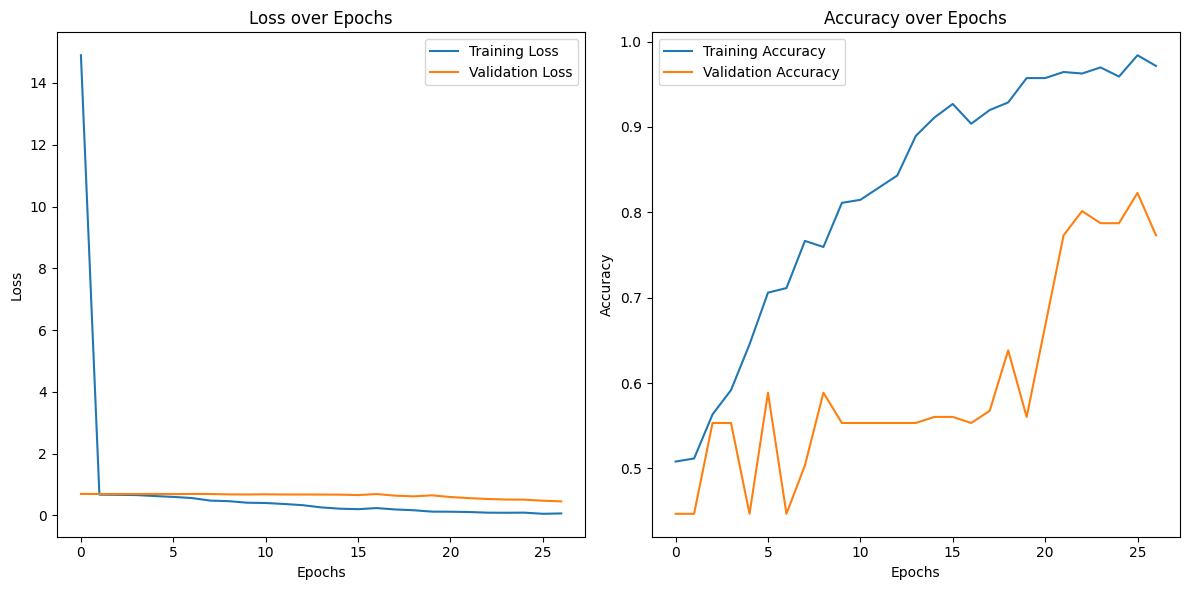

In [ ]:
plot_history(history_callback.df_history.loc[:, ['accuracy', 'val_accuracy', 'loss', 'val_loss']], save_path + 'model_1')

In [ ]:
# מומלץ להריץ
# הערכת המודל
test_results = model.evaluate(X_test, y_test)
test_loss, test_acc = test_results[0], test_results[1]
print(f'Loss: {round(test_loss, 6)}, Accuracy: {round(test_acc * 100, 3)}%')

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7582 - f1_score: 0.7577 - loss: 0.4661 - precision: 0.7582 - recall: 0.7582
Loss: 0.470707, Accuracy: 77.273%


In [ ]:
# מומלץ להריץ
# בחינת מודל עבור כל קבוצת הבחינה
predictions = np.argmax(model.predict(X_test), axis=1)
print("test len:" + str(len(X_test)))
accuracy_checker = 0
for i in range(len(X_test)):
    print('Image %d => Predicted: %d (expected %d)' % (i, predictions[i], np.argmax(y_test[i])))
    if predictions[i] == np.argmax(y_test[i]):
      accuracy_checker += 1
print(f'Accuracy: {accuracy_checker/len(X_test)}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
test len:176
Image 0 => Predicted: 0 (expected 1)
Image 1 => Predicted: 1 (expected 1)
Image 2 => Predicted: 0 (expected 0)
Image 3 => Predicted: 1 (expected 1)
Image 4 => Predicted: 1 (expected 1)
Image 5 => Predicted: 0 (expected 0)
Image 6 => Predicted: 0 (expected 0)
Image 7 => Predicted: 0 (expected 0)
Image 8 => Predicted: 0 (expected 0)
Image 9 => Predicted: 0 (expected 1)
Image 10 => Predicted: 1 (expected 1)
Image 11 => Predicted: 1 (expected 0)
Image 12 => Predicted: 0 (expected 0)
Image 13 => Predicted: 1 (expected 1)
Image 14 => Predicted: 0 (expected 0)
Image 15 => Predicted: 1 (expected 1)
Image 16 => Predicted: 1 (expected 0)
Image 17 => Predicted: 1 (expected 1)
Image 18 => Predicted: 1 (expected 1)
Image 19 => Predicted: 0 (expected 0)
Image 20 => Predicted: 1 (expected 0)
Image 21 => Predicted: 1 (expected 1)
Image 22 => Predicted: 0 (expected 0)
Image 23 => Predicted: 0 (expected 1)
Image 24 => Predicted: 0 (expected 1)
Image 25 =>

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 941ms/step


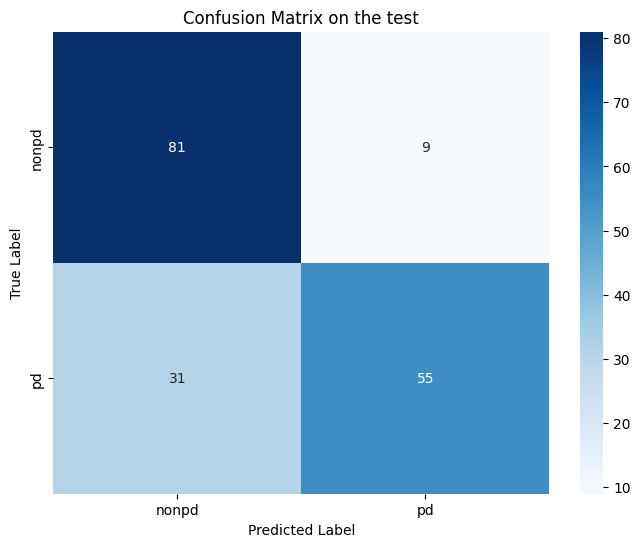

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Get predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["nonpd", "pd"]
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on the test")
plt.show()


In [ ]:
# שמירת המודל והמשקולות
model.save ( save_path +  'First_model_convolutional_network.keras' )
model.save ( save_path +  'First_model_convolutional_network.h5' )
model.save_weights ( save_path +  'First_model_convolutional_network_weight.weights.h5')